In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pprintpp
pprintpp.monkeypatch() 

from multiprocessing.pool import Pool

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

import re
import multiprocessing
from collections import Counter
import itertools
import pickle
import json
from IPython.display import display as disp
from sklearn.tree import export_graphviz 
from sklearn.tree import DecisionTreeClassifier
import graphviz 
import subprocess

import numpy as np
# import bottleneck as bn
import pandas as pd
import networkx as nx
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.cm.rocket.set_bad([0.01060815, 0.01808215, 0.10018654])
mpl.cm.inferno.set_bad('k')
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=2.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
%matplotlib inline
sns.set_palette(colorcycle)

# import warnings
# warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
# warnings.simplefilter("ignore", category=UserWarning)


from speclib import misc, loaders, graph, plotting

pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=145)

mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['figure.figsize'] = [12, 7] 

# import pixiedust

/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/pprintpp/__init__.py:171: UserWarning: 'pprint' has already been imported; monkeypatching won't work everywhere.
  warnings.warn("'pprint' has already been imported; monkeypatching "


In [2]:
mpl.rcParams['figure.figsize'] = [12, 7] 

# Plot decision tree

Make a decision tree plot for the report

In [3]:
data_path = '../../allan_data/DataPredictMovement_half.p'
x, y = np.load(data_path)
x = x
xx_tr = x[:8000, :] 
yy_tr = y[:8000] 

In [5]:
graphs = list()
for name, depth, max_leaf_nodes in [('shallow', 2, 8), ('deep', 16, 60)]:
    tree = DecisionTreeClassifier(max_depth=depth, class_weight=None,
                                  criterion='entropy', max_leaf_nodes=max_leaf_nodes) 

    tree.fit(xx_tr, yy_tr)

    columns = [f"{cha}_{qrt}" for cha in "Call SMS GPS Bluetooth".split() for qrt in range(1, 9)] 

    dot_data = export_graphviz(tree, out_file=None, feature_names=columns, class_names=["Didn't move", "Did move"],
                               filled=True, impurity=True, leaves_parallel=True, rounded=True,
                               special_characters=True)
    dot_data = dot_data.replace('helvetica', '"CMU Sans Serif"') 
    with open(f'decision_tree_example_{name}.dot', 'w') as fid:
        fid.write(dot_data)

    graphs.append(graphviz.Source(dot_data))

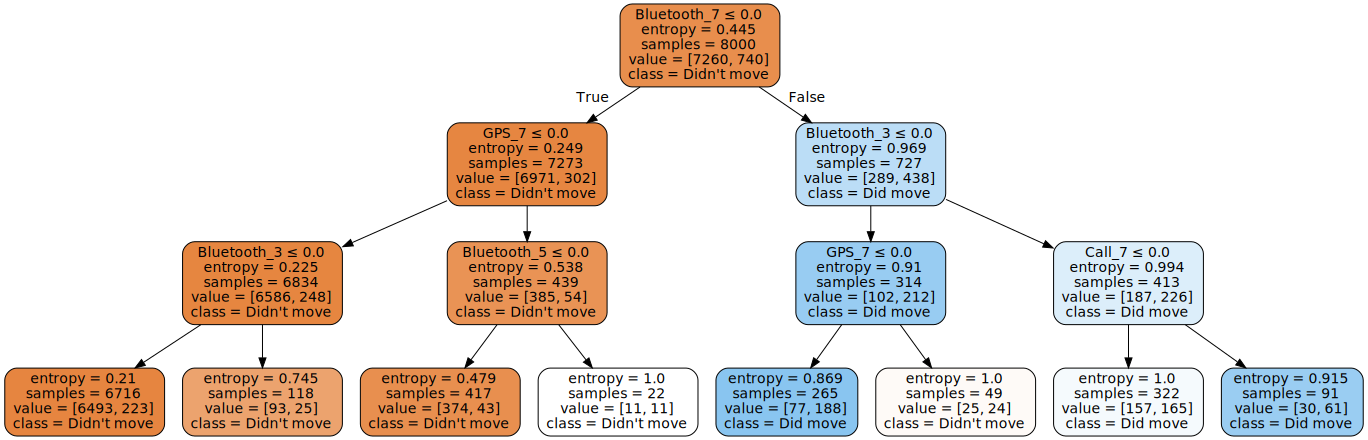

In [4]:
graphs[0]

In [5]:
print(subprocess.call(
     'dot -Tpdf decision_tree_example_shallow.dot -o figs/decision_tree_example_shallow.pdf',
      shell=True))
print(subprocess.call(
     'dot -Tpdf decision_tree_example_deep.dot  -o figs/decision_tree_example_deep.pdf',
      shell=True)) 

0
0


In [5]:
with open('userMovement_rf_coarse.pkl', 'br') as fid:
    rfc = pickle.load(fid) 
with open('userMovement_rf_finer.pkl', 'br') as fid:
    rff = pickle.load(fid)

In [6]:
rfc.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
     ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [7]:
rfc.validation_auc_score

0.8589634875117511

In [8]:
rfc.best_score_

0.8584558041362306

In [9]:
rfc.validation_auc_score - rfc.best_score_

0.0005076833755205401

In [10]:
est = rfc.best_estimator_.steps[1][1] 

In [11]:
est.feature_importances_.shape

(32,)

In [12]:
tr0 = est.estimators_[0]
columns = np.array([f"{cha}{qrt}" for cha in "CSGB" for qrt in range(1, 9)])
feature_importance = np.zeros((len(est.estimators_), len(tr0.feature_importances_)))
for i, tr in enumerate(est.estimators_):
    feature_importance[i, :] = tr.feature_importances_ 
fi = pd.DataFrame(feature_importance, columns=columns)
fi.columns.name = 'Communication channel'
fi.index.name = "Tree" 

In [13]:
fi = fi[fi.mean().sort_values(ascending=False).index] * 100

In [14]:
fi.head() 

Communication channel,B7,B3,G7,G3,S7,...,C6,S5,S1,C5,C1
Tree,,,,,,,,,,,
0,44.911739,35.679640,0.976231,1.277292,1.337043,...,0.254748,0.172246,0.279923,0.171319,0.181755
1,77.268876,2.934542,2.970511,0.707058,0.798130,...,0.249481,0.196723,0.159604,0.162971,0.181244
2,75.404045,4.641294,2.561013,2.451872,0.564517,...,0.298924,0.180989,0.173417,0.176871,0.152236
3,52.733662,33.823561,0.718640,1.674308,0.695750,...,0.220801,0.222329,0.176601,0.183128,0.201160
4,80.813430,3.792741,1.388992,2.500923,0.651349,...,0.198659,0.179466,0.188586,0.184450,0.172293


In [15]:
cat_dct = {'B': 0.0, 'C': 1.0, 'G': 2.0, 'S': 3.0} 
cat = pd.Series(fi.columns.str[0].map(lambda s: cat_dct[s]), index=fi.columns) 

In [16]:
fi_agg = pd.DataFrame([fi.mean(), fi.median(), fi.std(), cat], index=['Feature importance', 'median', 'std', 'cat']).T
fi_agg.head() 

,Feature importance,median,std,cat
Communication channel,,,,
B7,60.635047,59.206065,15.640734,0.0
B3,14.030777,5.922327,12.831086,0.0
G7,5.376852,2.358156,5.762392,2.0
G3,3.488555,1.674308,4.171598,2.0
S7,1.740810,0.798130,2.083635,3.0


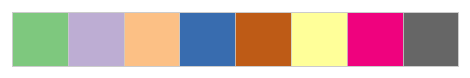

In [17]:
sns.palplot(colorcycle)  

In [18]:
palette = {f'{ch}{j}': colorcycle[i] for (i, ch) in enumerate('CSGB') for j in range(9)} 

Text(0.5,0,'Feature importance \\%')

figs/random_forest_important_features_linear_strip.pdf


Text(0.5,0,'Feature importance \\%')

figs/random_forest_important_features_linear_box.pdf


Text(0.5,0,'Feature importance \\%')

figs/random_forest_important_features_logarithmic_strip.pdf


Text(0.5,0,'Feature importance \\%')

figs/random_forest_important_features_logarithmic_box.pdf


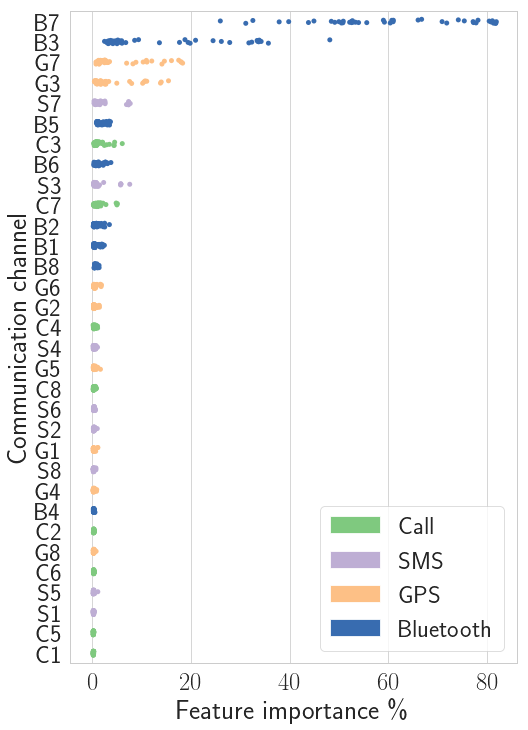

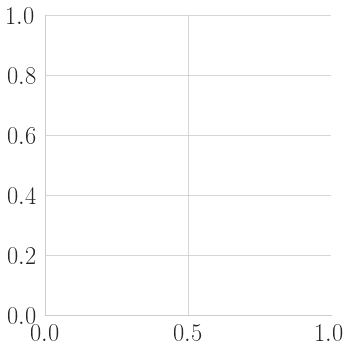

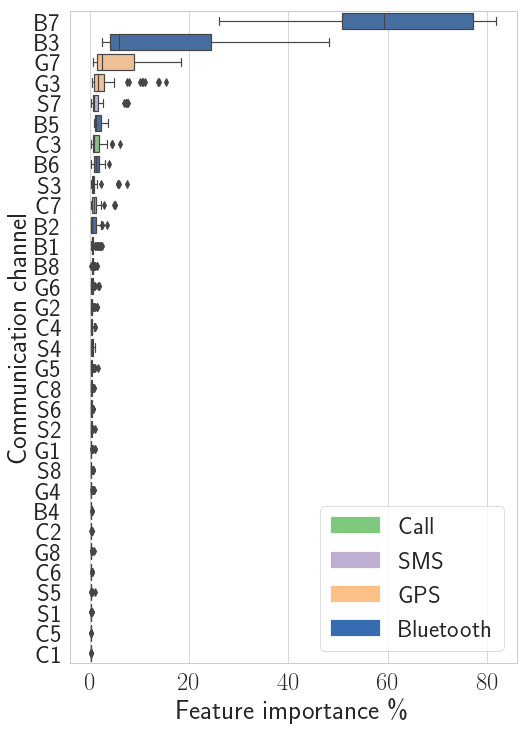

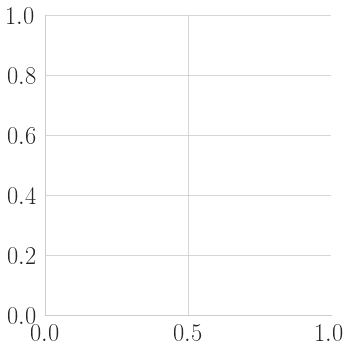

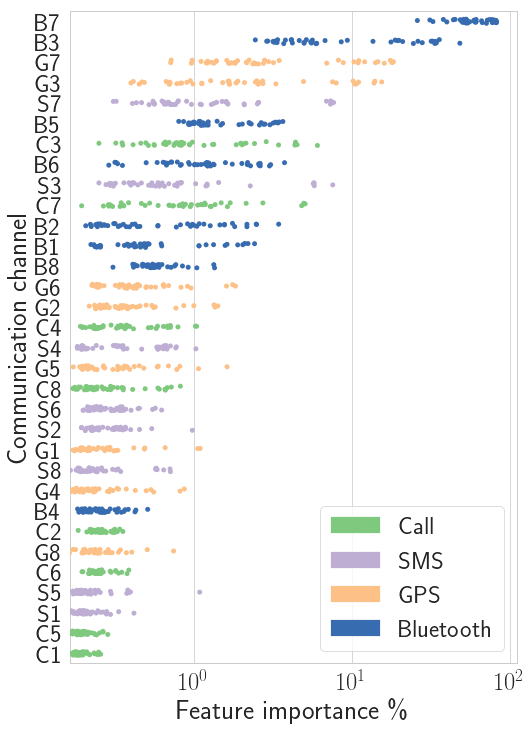

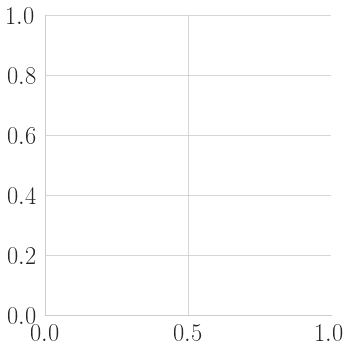

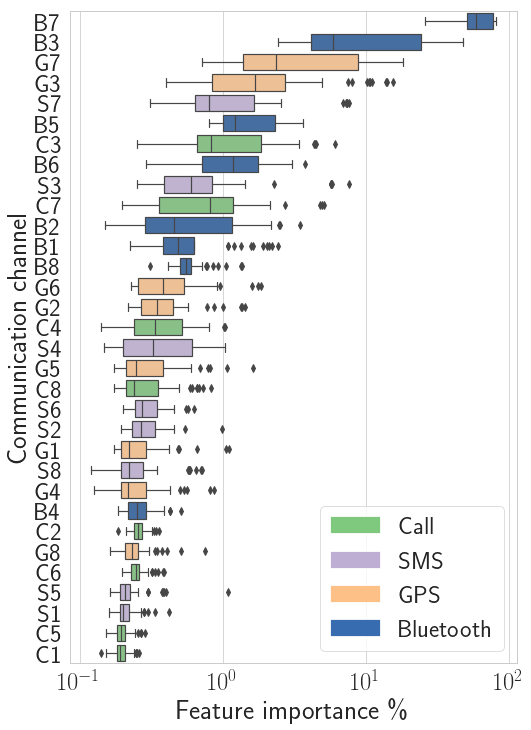

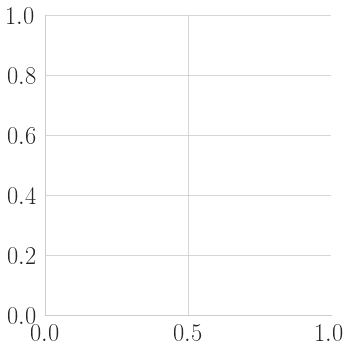

In [19]:
for log_switch, kind in itertools.product([False, True], ('strip', 'box')):
    fig, ax = plt.subplots(figsize=(8, 12)) 
    sns.catplot(data=fi, orient='h', palette=palette, kind=kind, ax=ax);
    ax.set_xlabel('Feature importance \\%');
    custom_lines = [mpl.patches.Patch(facecolor=colorcycle[0]),
                    mpl.patches.Patch(facecolor=colorcycle[1]), 
                    mpl.patches.Patch(facecolor=colorcycle[2]),
                    mpl.patches.Patch(facecolor=colorcycle[3])]
    ax.legend(custom_lines, ["Call", "SMS", "GPS", "Bluetooth"], loc="lower right");
    if log_switch:
        ax.set_xscale('log')
    logname = 'logarithmic' if log_switch else 'linear'
    # fig.savefig(f'figs/random_forest_important_features_{logname}_{kind}.pdf') 
    print(f'figs/random_forest_important_features_{logname}_{kind}.pdf')

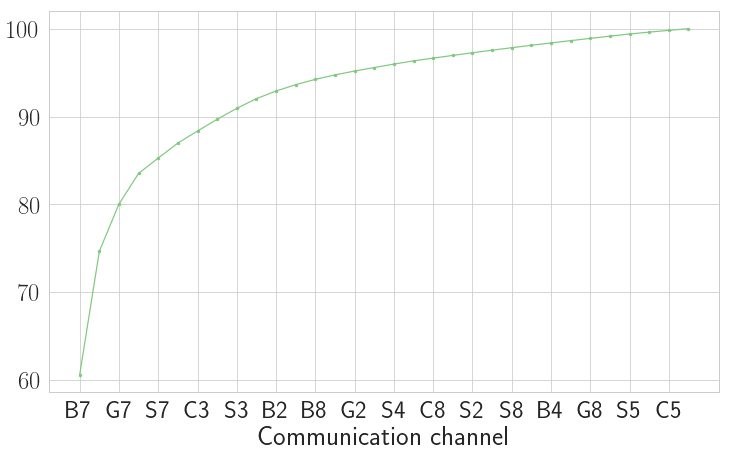

In [20]:
ax = fi_agg['Feature importance'].cumsum().plot(style='.-')
xticks, xlabels = list(zip(*((i, fi_agg.index[i]) for i in range(0, fi_agg.shape[0], 2))))
_ = ax.set_xticks(xticks) 
_ = ax.set_xticklabels(xlabels)

In [21]:
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
sns.set_palette(colorcycle)

Text(0.5,0,'Communication channel')

Text(0,0.5,'Tree')

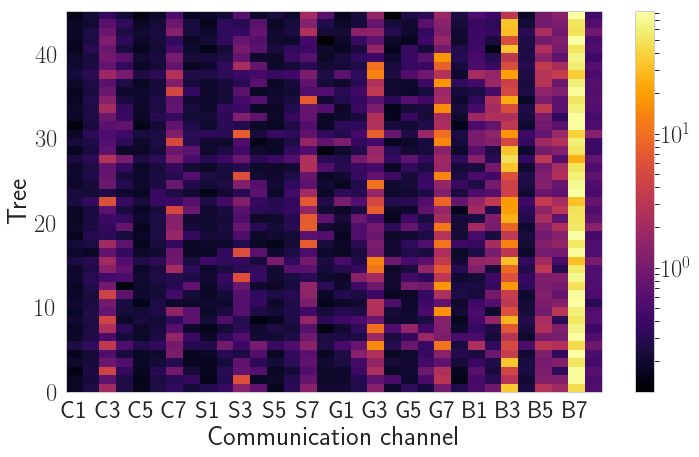

In [22]:
fig, ax = plt.subplots()
log_norm = mpl.colors.LogNorm(vmin=fi[columns].min().min(), vmax=fi[columns].max().max())
pc = ax.pcolorfast(fi[columns].values, norm=log_norm, cmap='inferno')
xticks, xlabels = list(zip(*[(i+0.5, columns[i]) for i in range(0, len(columns), 2)]))
_ = ax.set_xticks(xticks)
_ = ax.set_xticklabels(xlabels)
plt.grid(False)
ax.set_xlabel("Communication channel")
ax.set_ylabel("Tree")
fig.colorbar(pc, ax=ax) 
fig.savefig("figs/random_forest_feature_importance_heatmap_logarithmic.pdf")

In [23]:
tr0.tree_.node_count

31331

In [24]:
n_tree_nodes = np.array([tr.tree_.node_count for tr in est.estimators_])

(array([1., 0., 0., 0., 1., 0., 0., 1., 3., 1., 1., 2., 4., 6., 8., 2., 7., 0., 2., 4., 0., 0., 0., 1., 1.]),
 array([29423.  , 29647.08, 29871.16, 30095.24, 30319.32, 30543.4 , 30767.48, 30991.56, 31215.64, 31439.72, 31663.8 , 31887.88, 32111.96,
        32336.04, 32560.12, 32784.2 , 33008.28, 33232.36, 33456.44, 33680.52, 33904.6 , 34128.68, 34352.76, 34576.84, 34800.92, 35025.  ]),
 <a list of 25 Patch objects>)

Text(0.5,0,'Number of splits in tree')

Text(0,0.5,'Trees')

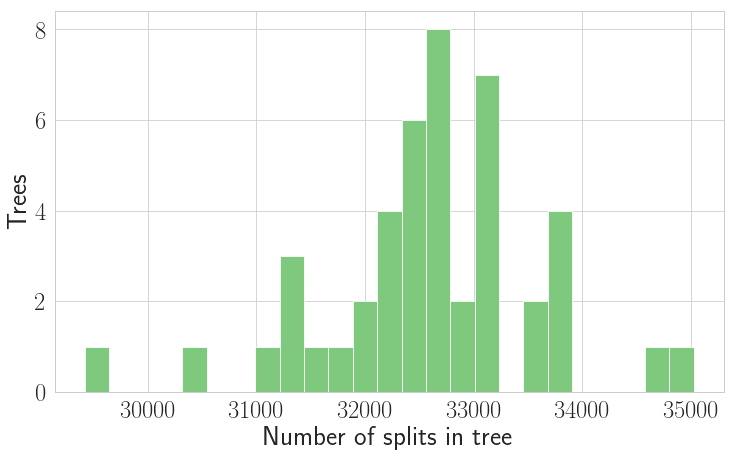

In [25]:
fig, ax = plt.subplots()
ax.hist(n_tree_nodes, 25)
ax.set_xlabel(r"Number of splits in tree")
ax.set_ylabel(r"Trees")
fig.savefig("figs/random_forest_number_of_nodes_in_trees.pdf")

## About the following code

The following code parses the decision trees in the random forest as a NetworkX graph.
It does so by using the build in tree-to-graphviz dot language converter, and parsing that code.


In [26]:
kw_rx = re.compile(r'(?P<key>\S+) = (?P<value>.+)')
op_rx = re.compile(r'(?P<key>\S+) (?P<operator>\S=) (?P<value>.+)')
ed_rx = re.compile(r'^(\d+) -> (\d+)') 

In [27]:
x_rx = re.compile(r'X\[(\d{1,2})\]')

def parse_label(label):
    m = x_rx.search(label)
    if m:
        return int(m.groups()[0]) 
    return None

In [28]:
def tree2nxgraph(tr):
    dot_file = export_graphviz(tr, out_file=None)
    nodes, edges = list(), list()
    for line in dot_file.split('\n'):
        try:
            if '[label=' in line:
                start = line.find('"') + 1
                end = line.find('"', start)
                lbl = line[start:end]
                nodes.append((int(line.split(' ', maxsplit=1)[0]), parse_label(lbl)))
                continue
            elif '->' in line:
                a, b = ed_rx.search(line).groups()
                edges.append((int(a), int(b)))
            else:
                # print("Didn't read", repr(line))
                pass
        except:  # noqa
            print(line)
    g = nx.DiGraph()
    for nid, attr in nodes:
        g.add_node(nid, nodeattr=attr)
    g.add_edges_from(edges)
    return g, nodes

In [29]:
def tree_stat_summary(g, nodes):
    outdeg_arr     = np.array(g.out_degree)
    outdeg_count   = pd.value_counts(outdeg_arr[:, 1])
    node_splits    = outdeg_arr[(outdeg_arr[:, 1] == 2), 0]
    dist_from_root = [nx.shortest_path_length(g, 0, nd) for nd in node_splits]


    nodeattr  = nx.get_node_attributes(g, 'nodeattr')
    splits    = np.array(nodes)[:, 1]
    splits_vc = pd.value_counts(splits, dropna=False)

    narr = np.array(nodes)
    narr_vc = pd.value_counts(narr[:, 1])

    root_distance = np.zeros((16, 32), dtype=int)
    rootdf = list()
    for i, (nd, sv) in enumerate(((nd, sv) for (nd, sv) in nodes if g.out_degree[nd] == 2)):
        dst = nx.shortest_path_length(g, 0, nd)
        root_distance[dst, sv] += 1
        rootdf.append((nd, sv, dst))
    rootdf = pd.DataFrame(rootdf, columns="node variable distance".split())
    return outdeg_count, dist_from_root, splits_vc, root_distance, rootdf


In [30]:
with Pool(processes=16) as pool:
    estimators = pool.map(tree2nxgraph, est.estimators_)
    tree_stat_results = pool.starmap(tree_stat_summary, estimators) 

    root_distance_agg = np.zeros((16, 32))
    splits_vc_agg = pd.Series(index=list(range(32)) + [np.NaN])
    dist_from_root_agg = list()

    for outdeg_count, dist_from_root, splits_vc, root_distance, rootdf in tree_stat_results:
        root_distance_agg += root_distance
        splits_vc_agg += splits_vc 
        dist_from_root_agg.append(dist_from_root)

pool.close() 

Investigate the distance from the root, where a split using a given variable occurs.

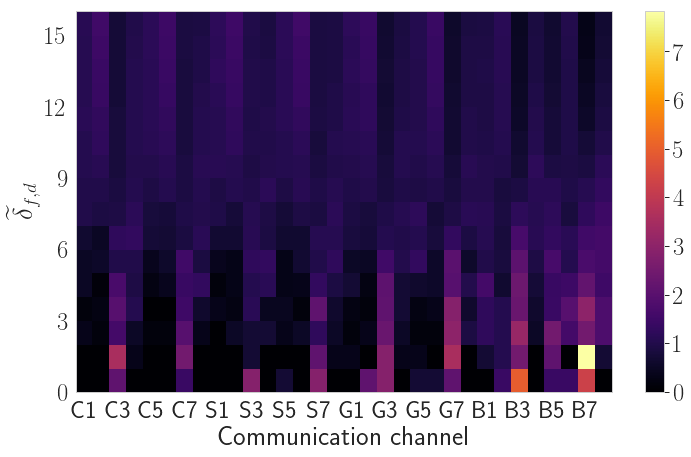

In [31]:
fig, ax = plt.subplots()
rdac = root_distance_agg / (root_distance_agg.mean(axis=1)[:, None])
pc = ax.pcolor(rdac, cmap='inferno')
fig.colorbar(pc, ax=ax)
xticks_incices = np.arange(0, 32, 2) 
_ = ax.set_yticks(np.arange(0, 16, 3)) 
_ = ax.set_xticks(xticks_incices + 0.5)
_ = ax.set_xticklabels([columns[i].upper() for i in xticks_incices]); 
_ = ax.set_ylabel(r"$\widetilde{\delta}_{f, d}$")
_ = ax.set_xlabel("Communication channel")
fig.savefig('figs/feature_split_distance_from_root_cumultative_normalized.pdf')

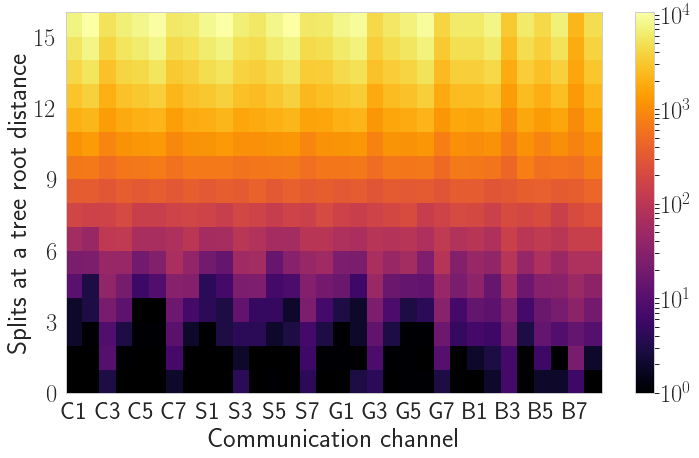

In [32]:
fig, ax = plt.subplots() 
data = root_distance_agg + 1
pc = ax.pcolor(root_distance_agg, norm=mpl.colors.LogNorm(), cmap='inferno')
fig.colorbar(pc)
xticks_incices = np.arange(0, 32, 2) 
_ = ax.set_yticks(np.arange(0, 16, 3)) 
_ = ax.set_xticks(xticks_incices + 0.5)
_ = ax.set_xticklabels([columns[i].upper() for i in xticks_incices])
_ = ax.set_ylabel("Splits at a tree root distance")
_ = ax.set_xlabel("Communication channel") 
# fig.savefig('figs/feature_split_distance_from_root.pdf')

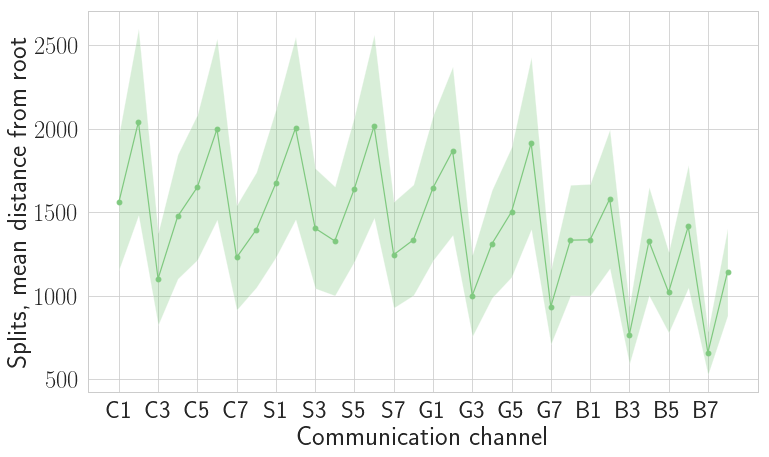

In [33]:
fig, ax = plt.subplots()
x = np.arange(root_distance_agg.shape[1])
y = root_distance_agg.mean(axis=0)
std = root_distance_agg.std(axis=0)/np.sqrt(32)
ax.fill_between(x, y-std, y+std, alpha=0.3)
ax.plot(x, y, '-o')
xticks_incices = np.arange(0, 32, 2) 
_ = ax.set_xticks(xticks_incices) 
_ = ax.set_xticklabels([columns[i].upper() for i in xticks_incices])
_ = ax.set_ylabel("Splits, mean distance from root")
_ = ax.set_xlabel("Communication channel")
fig.savefig('figs/mean_feature_split_distance_from_root.pdf') 

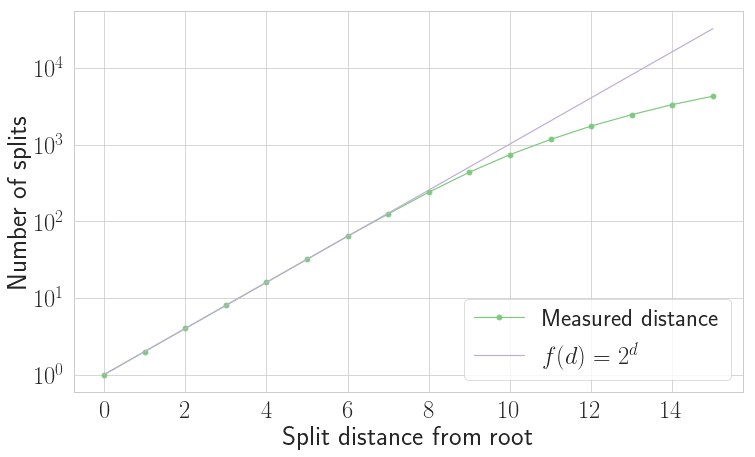

In [48]:
fig, ax = plt.subplots()
dist_from_root_vc = pd.value_counts(dist_from_root)[::-1]
dist_from_root_vc.index.name = "Split distance from root"
ax.set_yscale('log', basey=10)
_ = dist_from_root_vc.plot(kind='line', color=colorcycle[0], style=['-o'], label="Measured distance")
_ = ax.plot(np.arange(0, 16), 2**np.arange(0, 16), color=colorcycle[1], label="$f(d) = 2^d$")
_ = ax.set_ylabel("Number of splits")
_ = ax.legend(loc='lower right')
fig.savefig("figs/random_forest_number_of_splits_distance_from_root_histogram.pdf")

In [51]:
print(splits_vc)

NaN      14712
 9.0       702
 17.0      696
 1.0       649
 5.0       636
 13.0      636
 21.0      603
 25.0      602
 8.0       576
 12.0      559
 16.0      524
 2.0       514
 3.0       513
 6.0       511
 0.0       501
 20.0      495
 4.0       473
 11.0      464
 27.0      458
 10.0      453
 15.0      428
 22.0      428
 23.0      427
 31.0      426
 24.0      414
 29.0      409
 7.0       382
 26.0      367
 28.0      303
 19.0      256
 18.0      180
 14.0      125
 30.0        1
dtype: int64


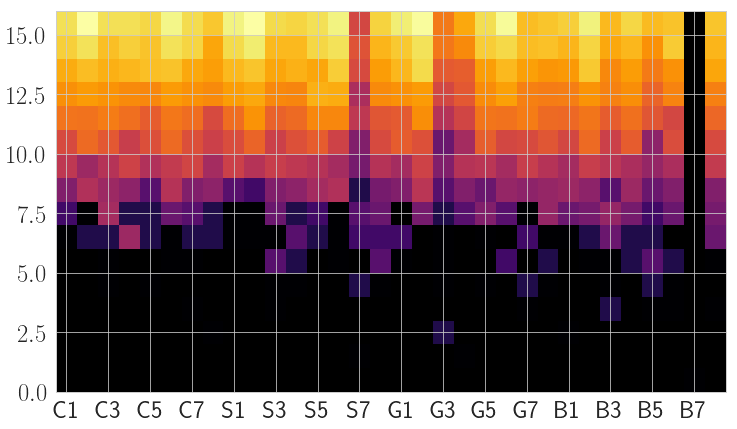

In [52]:
fig, ax = plt.subplots()
ax.pcolorfast(root_distance, norm=mpl.colors.LogNorm(), cmap='inferno') 
xticks_incices = np.arange(0, 32, 2) 
_ = ax.set_xticks(xticks_incices + 0.5)
_ = ax.set_xticklabels([columns[i].upper() for i in xticks_incices]); 

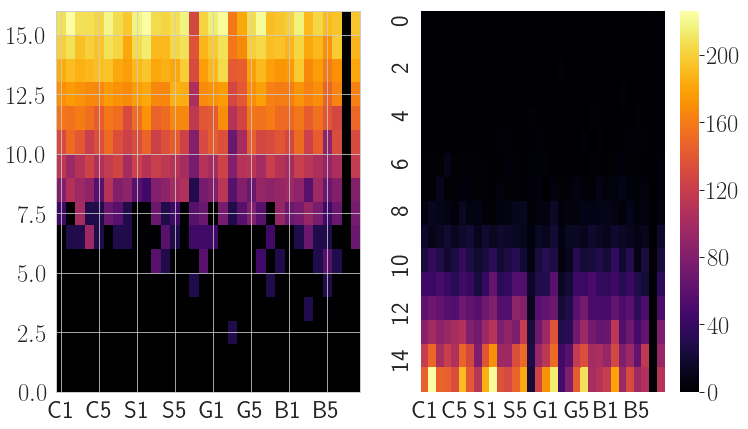

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.pcolorfast(root_distance, norm=mpl.colors.LogNorm(), cmap='inferno') 
# ax1.set_xticks(np.arange(32) + 0.5)
# ax1.set_xticklabels(columns);
xticks_incices = np.arange(0, 32, 4) 
_ = ax1.set_xticks(xticks_incices + 0.5)
_ = ax1.set_xticklabels([columns[i].upper() for i in xticks_incices]); 

sns.heatmap(data=root_distance, cmap='inferno') 
# ax2.set_xticks(np.arange(32) + 0.5)
# ax2.set_xticklabels(columns); 
_ = ax2.set_xticks(xticks_incices + 0.5)
_ = ax2.set_xticklabels([columns[i].upper() for i in xticks_incices]); 

# Detailed analysis of tree rules

The data are standardized as part of the learning process.

We start by working on the first tree

In [135]:
dc = rfc.best_estimator_.steps[1][1].estimators_[0] 

In [136]:
def parse_label2(label):
    label_rx = re.compile(r"""(?:X\[(?P<feature>\d+)\] (?P<relation>.=) (?P<threshold>[\d.]+))?
?(?P<lossfunction>\w+) = (?P<measure>[\d.]+)
samples = (?P<samples>\d+)
value = \[(?P<classA>\d+), (?P<classB>\d+)\]""", flags=re.MULTILINE)
    m = label_rx.search(label.replace('\\n', '\n'))
    if m:
        return m.groupdict()
    return None

In [137]:
def tree2nxgraph2(tr):
    dot_file = export_graphviz(tr, out_file=None)
    nodes, edges, labels = list(), list(), list()
    for i, line in enumerate(dot_file.split('\n')):
        try:
            if '[label=' in line:
                start = line.find('"') + 1
                end = line.find('"', start)
                lbl = line[start:end]
                labels.append(lbl)
                nodes.append((int(line.split(' ', maxsplit=1)[0]), parse_label2(lbl)))
                continue
            elif '->' in line:
                a, b = ed_rx.search(line).groups()
                edges.append((int(a), int(b)))
            else:
                # print("Didn't read", repr(line))
                pass
        except:  # noqa
            print(line)
    g = nx.DiGraph()
    for nid, attr in nodes:
        g.add_node(nid, nodeattr=attr)
    g.add_edges_from(edges)
    return g, nodes, labels

In [138]:
g, nodes, labels = tree2nxgraph2(dc) 

In [139]:
keys, vals = list(zip(*nodes))

In [190]:
df = pd.DataFrame(list(vals))
rep = {str(k): v for (k, v) in enumerate(columns.tolist())} 
df['feature'] = df.feature.replace(rep)
df['classA'] = df.classA.astype(int)
df['classB'] = df.classB.astype(int)
df['measure'] = df.classA.astype(float)
df['samples'] = df.samples.astype(int)
df['threshold'] = df.classA.astype(float)
df.head()  

,classA,classB,feature,lossfunction,measure,relation,samples,threshold
0,4764455,474821,B3,entropy,4764455.0,<=,3311996,4764455.0
1,4477714,292900,B5,entropy,4477714.0,<=,3015755,4477714.0
2,4394110,270588,C3,entropy,4394110.0,<=,2948871,4394110.0
3,4072368,229047,S3,entropy,4072368.0,<=,2718958,4072368.0
4,3883763,204921,B6,entropy,3883763.0,<=,2584329,3883763.0


In [191]:
b7 = df[df.feature == 'B7']
b7.head() 

,classA,classB,feature,lossfunction,measure,relation,samples,threshold
12,2908182,109134,B7,entropy,2908182.0,<=,1906846,2908182.0
44,104604,6140,B7,entropy,104604.0,<=,70128,104604.0
59,2393,402,B7,entropy,2393.0,<=,1811,2393.0
93,500,85,B7,entropy,500.0,<=,365,500.0
120,609,65,B7,entropy,609.0,<=,424,609.0


In [208]:
b7p = b7[(b7.threshold <= 2000)]

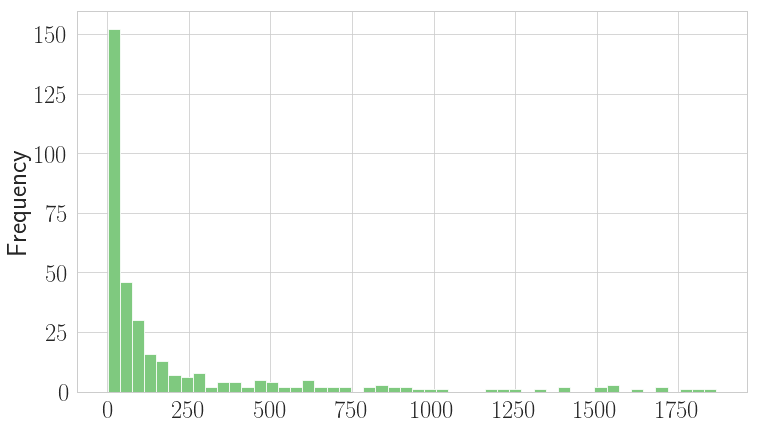

In [210]:
b7p.threshold.plot.hist(50) 

The thresholds seem to be all over the place, and no useful information can be discerned from looking at the them.